## **Latihan Hyperparameter Tuning**

**Gunakan dataset 'insurance'**

Carilah model dan hyperparameter terbaik untuk memprediksi biaya asuransi tiap individu berdasarkan karakteristiknya.
1. Lakukan EDA singkat untuk mengeksplorasi dataset terlebih dahulu.
2. Lakukan preprocessing pada features jika dibutuhkan.
3. Lakukan modeling dengan menggunakan linear regression, knn regressor, dan decision tree regressor.<br>
    Kandidat algoritma:
    - linreg = LinearRegression(fit_intercept=True)
    - knn = KNeighborsRegressor(n_neighbors=5)
    - tree = DecisionTreeRegressor(criterion='mae', min_samples_leaf=1, max_depth=5, random_state=0)
4. Pilih 1 model terbaik berdasarkan hasil cross validasi 3 model di atas.
5. Lakukan prediksi pada test set dari model terpilih (sebelum hyperparameter tuning).
6. Lakukan hyperparameter tuning pada model terpilih tsb.
7. Lakukan prediksi pada test set dari model dengan hyperparameter tuning.
8. Bandingkan hasil performa model sebelum dan sesudah tuning.

*Tips: Gunakan Pipeline*

**Features Description**

- age: age of primary beneficiary

- sex: insurance contractor gender, female, male

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- children: Number of children covered by health insurance / Number of dependents

- smoker: Smoking

- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- charges: Individual medical costs billed by health insurance

## **Import libraries**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

## **Load dataset**

In [3]:
df = pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### **Features Description**

- age: age of primary beneficiary

- sex: insurance contractor gender, female, male

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- children: Number of children covered by health insurance / Number of dependents

- smoker: Smoking

- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- charges: Individual medical costs billed by health insurance

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# check missing values
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
df.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


## **Simple EDA**

In [7]:
cat_features = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
cat_features

['sex', 'smoker', 'region']

In [8]:
num_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['charges']))]
num_features

['age', 'bmi', 'children']

In [9]:
# category pada categorical features
for i in cat_features:
    print(f'Total unique values in {i}: ', df[i].nunique())
    print(f'Unique values: ', df[i].unique())
    print()

Total unique values in sex:  2
Unique values:  ['female' 'male']

Total unique values in smoker:  2
Unique values:  ['yes' 'no']

Total unique values in region:  4
Unique values:  ['southwest' 'southeast' 'northwest' 'northeast']



In [10]:
df.corr()['charges']

age         0.299008
bmi         0.198341
children    0.067998
charges     1.000000
Name: charges, dtype: float64

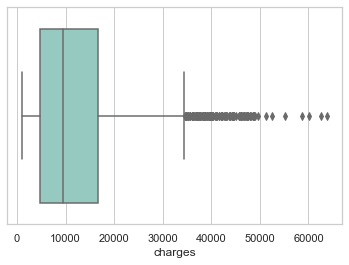

In [11]:
sns.set(style='whitegrid', palette='Set3')
sns.boxplot(x='charges', data=df);

### **Plot of categorical features**

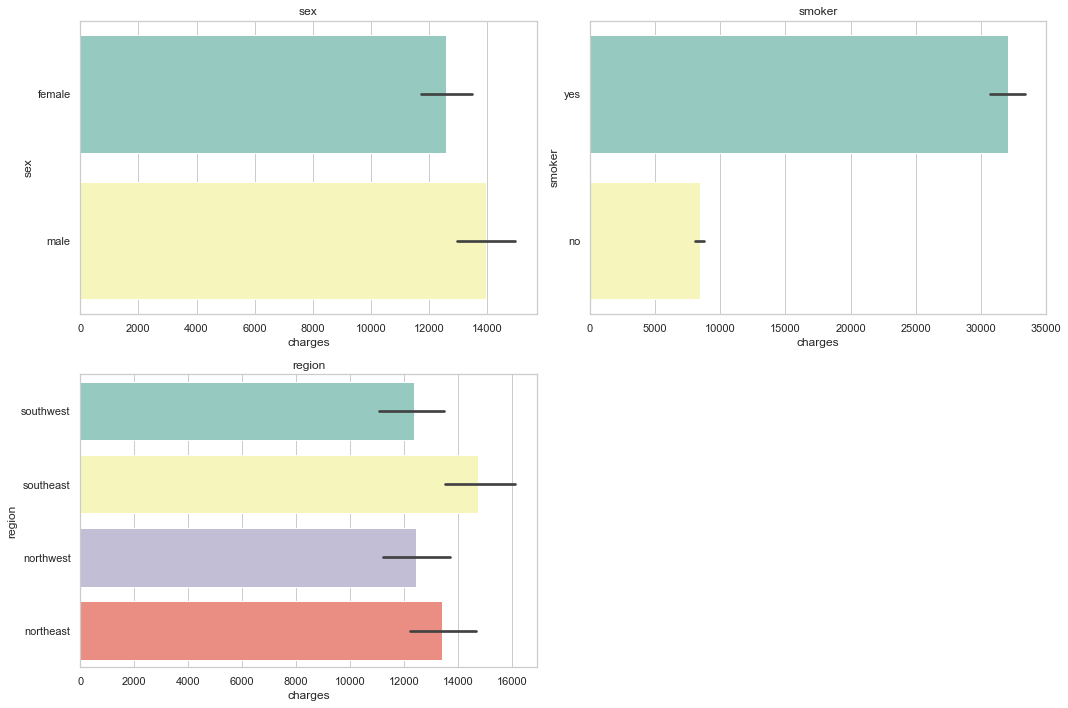

In [12]:
plt.figure(figsize=(15, 10), facecolor='white')
sns.set(style='whitegrid', palette='Set3')
plotnumber = 1

for feature in cat_features:
    ax = plt.subplot(2, 2, plotnumber)
    sns.barplot(x = 'charges', y = feature, data = df)
    plt.xlabel('charges')
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout();

### **Plot of numerical features**

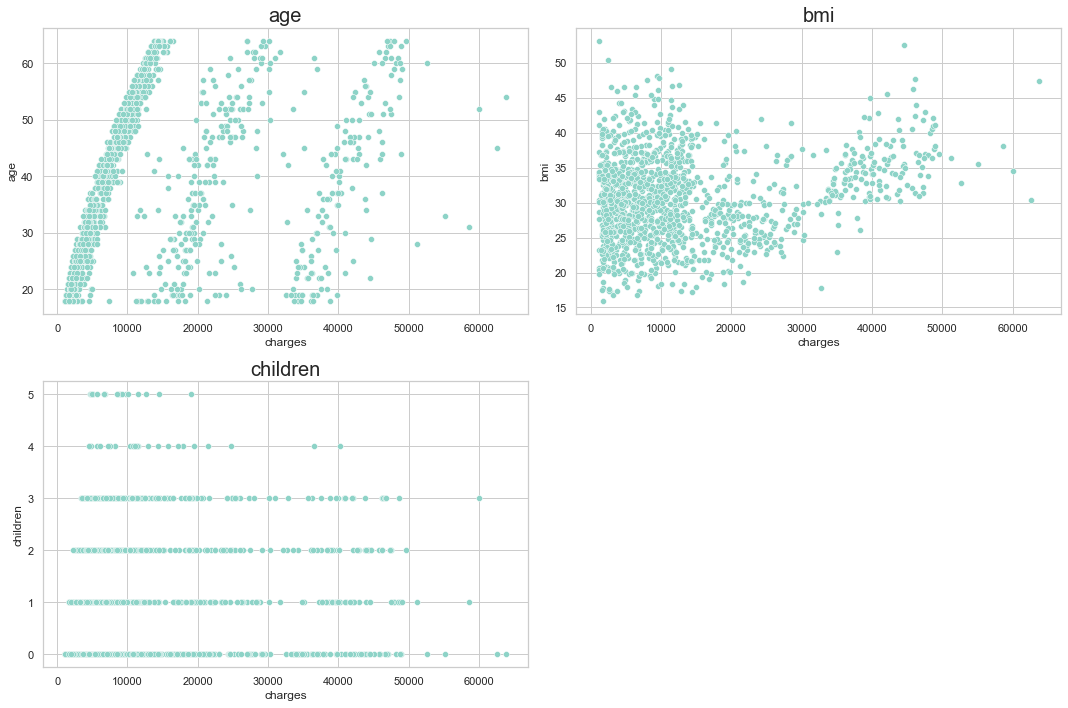

In [13]:
plt.figure(figsize=(15, 10), facecolor='white')
sns.set(style='whitegrid', palette='Set3')
plotnumber = 1

for feature in num_features:
    ax = plt.subplot(2, 2, plotnumber)
    sns.scatterplot(x = 'charges', y = feature, data = df)
    plt.xlabel('charges')
    plt.title(feature, fontsize=20)
    plotnumber += 1
    plt.tight_layout();

## **Data Splitting**

In [14]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [15]:
# Define X and y
X = df.drop(columns='charges')
y = df['charges']

In [16]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=0
)

## **Feature Transformation**

In [17]:
transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(drop='first'), ['sex', 'smoker', 'region'])
], remainder='passthrough')

In [18]:
# transform features (satu persatu, tanpa Pipeline)
X_train_prep = pd.DataFrame(transformer.fit_transform(X_train))
X_test_prep = pd.DataFrame(transformer.transform(X_test))

In [19]:
X_train_prep.head()

,0,1,2,3,4,5,6,7
0,1.0,1.0,0.0,0.0,1.0,37.0,34.100,4.0
1,1.0,0.0,0.0,1.0,0.0,18.0,34.430,0.0
2,0.0,1.0,0.0,0.0,0.0,23.0,36.670,2.0
3,1.0,0.0,0.0,0.0,1.0,32.0,35.200,2.0
4,0.0,0.0,0.0,0.0,0.0,58.0,32.395,1.0


## **Feature Scaling**

In [20]:
# scaling features (satu persatu, tanpa Pipeline)
scaler = RobustScaler()

X_train_prep_scaled = pd.DataFrame(scaler.fit_transform(X_train_prep))
X_test_prep_scaled = pd.DataFrame(scaler.transform(X_test_prep))

In [21]:
X_train_prep_scaled.head()

,0,1,2,3,4,5,6,7
0,1.0,1.0,0.0,0.0,1.0,-0.08,0.436449,1.5
1,1.0,0.0,0.0,1.0,0.0,-0.84,0.475376,-0.5
2,0.0,1.0,0.0,0.0,0.0,-0.64,0.739605,0.5
3,1.0,0.0,0.0,0.0,1.0,-0.28,0.566205,0.5
4,0.0,0.0,0.0,0.0,0.0,0.76,0.235329,0.0


## **Model Benchmark**
Mencari algoritma terbaik untuk digunakan pada dataset ini dengan menggunakan cross validation. Belum melakukan hyperparameter tuning 

In [22]:
# macam-macam metrics
from sklearn import metrics
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [23]:
# Define models (3 kandidat model)
linreg = LinearRegression(fit_intercept=True)
knn = KNeighborsRegressor(n_neighbors=5)
tree = DecisionTreeRegressor(criterion='mae', min_samples_leaf=1, max_depth=5, random_state=0)

In [24]:
# pilihan model algoritma
models = [linreg, knn, tree]

nilai_mean = []
nilai_std = []

# mencari model terbaik berdasarkan MAE terkecil
for i in models:
    
    model_cv = cross_val_score(
        i, 
        X_train_prep_scaled, # menggunakan X_train yang sudah di-tansform dan di-scaling
        y_train, 
        scoring = 'neg_mean_absolute_error')

    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

    print(i,'\n', model_cv)

LinearRegression() 
 [-4285.73672206 -3922.02986453 -4122.67469177 -4288.75441939
 -4758.76255886]
KNeighborsRegressor() 
 [-4012.41029687 -3063.47497909 -3904.70236337 -3559.85774314
 -4240.09854134]
DecisionTreeRegressor(criterion='mae', max_depth=5, random_state=0) 
 [-1914.71916079 -1804.28627757 -2047.27315308 -2297.89898161
 -2637.65756484]


In [25]:
# Perbandingan performa antar model
pd.DataFrame({
    'model':['Linear Regression', 'KNN Regressor', 'Decision Tree Regressor'],
    'mean': nilai_mean,
    'std': nilai_std
})

 

,model,mean,std
0,Linear Regression,-4275.591651,276.448853
1,KNN Regressor,-3756.108785,409.944548
2,Decision Tree Regressor,-2140.367028,298.210629


**WARNING!!!**
- Tahap modeling seperti di atas ini (preprocessingnya manual) tidak direkomendasikan karena dapat menimbulkan information leakage.
- Nanti bisa bandingkan score KNN di sini (preprocessingnya manual) dengan setelah ini (preprocessingnya dengan Pipeline).
- Score (khususnya KNN) di sini lebih bagus dari pada yang menggunakan Pipeline, karena di sini (preprocessing manual) terjadi information leakage. 

## **Model Benchmark (dengan Pipeline)**
- Di sini kita coba melakukan modeling dengan pipeline (transform dan scaling feature dilakukan dalam satu tahap).
- Disarankan menggunakan Pipeline untuk menghindari information leakage.
- Contoh yang benar: pada Split 1, seharusnya Fold 1 tidak ikut di-fit_transform, seharusnya Fold 1 hanya di-transform saja 
- Dengan menggunakan Pipeline, pada Split 1, otomatis Fold 1 tidak ikut di-fit_transform, tetapi Fold 1 hanya di-transform saja.  

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt="Drawing" style="width: 600px;"/>


In [26]:
# pilihan model algoritma
models = [linreg, knn, tree]

nilai_mean = []
nilai_std = []

# mencari model terbaik berdasarkan MAE terkecil
for i in models:

    # Pipeline berisi 3 tahap, untuk diisi di pada estimator di cross val
    estimator=Pipeline([
                        ('preprocess', transformer),
                        ('scaler', RobustScaler()),
                        ('model', i)
                    ])

    # cross val
    model_cv = cross_val_score(
        estimator = estimator, 
        X = X_train, # menggunakan X_train awal (karena transform dan scaling dilakukan di Pipeline)
        y = y_train, 
        cv = 5,
        scoring = 'neg_mean_absolute_error'
        )

    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

    print(i,'\n', model_cv)


LinearRegression() 
 [-4285.73672206 -3922.02986453 -4122.67469177 -4288.75441939
 -4758.76255886]
KNeighborsRegressor() 
 [-4012.41029687 -3091.45318916 -3970.39145394 -3551.54160968
 -4253.57736236]
DecisionTreeRegressor(criterion='mae', max_depth=5, random_state=0) 
 [-1914.71916079 -1804.28627757 -2047.27315308 -2297.89898161
 -2637.65756484]


In [27]:
# Perbandingan performa antar model
pd.DataFrame({
    'model':['Linear Regression', 'KNN Regressor', 'Decision Tree Regressor'],
    'mean': nilai_mean,
    'std': nilai_std
})

,model,mean,std
0,Linear Regression,-4275.591651,276.448853
1,KNN Regressor,-3775.874782,410.059466
2,Decision Tree Regressor,-2140.367028,298.210629


### **Interpretasi**

- Dari ketiga model yang dicoba, ternyata model decision tree regressor menghasilkan error yang paling kecil, dengan perbedaan yang cukup signifikan.
- Decision Tree Regressor juga cukup stabil, walauun Linear Regressio sedikit lebih stabil 
- Untuk selanjutnya, hanya model decision tree regressor saja yang akan diuji pada test set dan juga dilakukan tuning.

## **Model Performance in Test Set**
Sekarang kita predict model tree-nya pada Test set dan lihat hasil performanya

In [28]:
# model benchmark
tree_pipeline = Pipeline([
    ('preprocess', transformer),
    ('scaler', RobustScaler()),
    ('model', tree)
])

# fitting
tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('scaler', RobustScaler()),
                ('model',
                 DecisionTreeRegressor(criterion='mae', max_depth=5,
                                       random_state=0))])

In [29]:
# predict
y_pred = tree_pipeline.predict(X_test)

In [30]:
# Metric evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)

MSE: 24249019.226462997
RMSE: 4924.329317426181
MAE: 1985.4698345485076


## **Hyperparameter Tuning**
Cari hyperparameter terbaik untuk decision tree

In [31]:
# hyperparameter yang akan diisikan pada model (tree)
hyperparam_space = {
    'model__criterion':['mae','mse'],                    # benchmark: mae
    'model__min_samples_leaf': [1, 5, 10, 15, 20, 50],   # benchmark: 1
    'model__max_depth':[5, 6, 7, 8, 9, 10]               # benchmark: 5
    # 'scaler':[StandardScaler(), MinMaxScaler(), RobustScaler()]
} 

In [32]:
# model benchmark
tree = DecisionTreeRegressor(criterion='mae', min_samples_leaf=1, max_depth=5, random_state=0)

# model dalam pipeline
tree_pipeline = Pipeline([
    ('preprocess', transformer),
    ('scaler', RobustScaler()),
    ('model', tree)
])


# Grid search (mencari hyperparameter terbaik)
grid_search = GridSearchCV(
    estimator = tree_pipeline,           # model to tune
    param_grid = hyperparam_space,       # hyperparam space
    cv = 5,
    scoring = 'neg_mean_absolute_error', # metric
    n_jobs= -1
) 

In [33]:
# estimator.get_params().keys()

In [34]:
# fit grid_search pada train set
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('scaler', RobustScaler()),
                                       ('model',
                                        DecisionTreeRegressor(criterion='mae',
                                                              max_depth=5,
                                                          

In [35]:
# score terbaik hasil dari grid_search
print(grid_search.best_score_)

# hyperparameter pada score terbaik hasil dari grid_search
print(grid_search.best_params_)

-1938.7420199112148
{'model__criterion': 'mae', 'model__max_depth': 6, 'model__min_samples_leaf': 5}


In [36]:
# hasil dari 72 kombinasi hyperparameter
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,param_model__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.256813,0.078174,0.041793,0.019548,mae,2,1,"{'model__criterion': 'mae', 'model__max_depth'...",-3018.214146,-3016.596530,-3237.546635,-3080.346853,-3971.275395,-3264.795912,362.293455,61
1,0.205976,0.065744,0.034415,0.023136,mae,2,5,"{'model__criterion': 'mae', 'model__max_depth'...",-3018.214146,-3016.596530,-3237.546635,-3080.346853,-3971.275395,-3264.795912,362.293455,61
2,0.162829,0.027911,0.038647,0.016522,mae,2,10,"{'model__criterion': 'mae', 'model__max_depth'...",-3018.214146,-3016.596530,-3237.546635,-3080.346853,-3971.275395,-3264.795912,362.293455,61
3,0.229847,0.060605,0.075913,0.046671,mae,2,15,"{'model__criterion': 'mae', 'model__max_depth'...",-3018.214146,-3016.596530,-3237.546635,-3080.346853,-3971.275395,-3264.795912,362.293455,61
4,0.268099,0.072325,0.069126,0.056212,mae,2,20,"{'model__criterion': 'mae', 'model__max_depth'...",-3018.214146,-3016.596530,-3237.546635,-3080.346853,-3971.275395,-3264.795912,362.293455,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.135584,0.022035,0.051504,0.021512,mse,7,5,"{'model__criterion': 'mse', 'model__max_depth'...",-2700.516699,-2503.205790,-3024.150800,-2938.894057,-3135.503424,-2860.454154,228.826526,46
68,0.105178,0.025992,0.036214,0.016960,mse,7,10,"{'model__criterion': 'mse', 'model__max_depth'...",-2806.844741,-2510.348797,-2860.628980,-2903.029366,-3249.274635,-2866.025304,235.918031,47
69,0.072203,0.029621,0.056237,0.048257,mse,7,15,"{'model__criterion': 'mse', 'model__max_depth'...",-2863.568116,-2403.908351,-2794.996947,-2942.761621,-3134.642955,-2827.975598,240.586013,44
70,0.084548,0.023243,0.044880,0.020456,mse,7,20,"{'model__criterion': 'mse', 'model__max_depth'...",-2743.333355,-2448.336847,-2714.291711,-2956.625994,-3228.479302,-2818.213442,261.033163,42


In [37]:
# model dengan score tertinggi
pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,param_model__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,0.207359,0.050211,0.045331,0.015850,mae,6,5,"{'model__criterion': 'mae', 'model__max_depth'...",-1816.997610,-1674.227427,-1797.405596,-1862.364071,-2542.715395,-1938.742020,308.344964,1
31,0.203454,0.054317,0.035543,0.012963,mae,7,5,"{'model__criterion': 'mae', 'model__max_depth'...",-1861.403725,-1605.538089,-1886.771645,-1878.334412,-2521.859691,-1950.781513,304.189922,2
32,0.245377,0.025125,0.024027,0.019852,mae,7,10,"{'model__criterion': 'mae', 'model__max_depth'...",-1838.377226,-1693.533349,-1824.945265,-1890.404402,-2525.466208,-1954.545290,292.739873,3
26,0.189577,0.009740,0.036616,0.010838,mae,6,10,"{'model__criterion': 'mae', 'model__max_depth'...",-1851.216760,-1733.188896,-1836.659679,-1928.281755,-2526.977915,-1975.265001,282.770156,4
33,0.244466,0.032088,0.023722,0.013857,mae,7,15,"{'model__criterion': 'mae', 'model__max_depth'...",-1836.121452,-1752.811728,-1918.411131,-2002.681131,-2599.106583,-2021.826405,300.389377,5


## **Model Performance in Test Set with best hyperparameter**

In [38]:
grid_search.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('scaler', RobustScaler()),
                ('model',
                 DecisionTreeRegressor(criterion='mae', max_depth=6,
                                       min_samples_leaf=5, random_state=0))])

In [39]:
# Model setelah hyperparameter tuning
best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('scaler', RobustScaler()),
                ('model',
                 DecisionTreeRegressor(criterion='mae', max_depth=6,
                                       min_samples_leaf=5, random_state=0))])

In [40]:
# predict
y_pred_best = best_model.predict(X_test)

In [41]:
# Score pada test set
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test, y_pred_best)

print('MSE:', mse_best)
print('RMSE:', rmse_best)
print('MAE:', mae_best)

MSE: 16994102.233397037
RMSE: 4122.390354320783
MAE: 1678.1435176455223


## **Comparison of before and after tuning**
Perbandingan performa pada Test set

In [42]:
pd.DataFrame({
    'Metrics->':['Before tuning', 'After tuning'],
    'RMSE':[rmse,rmse_best], 
    'MAE':[mae, mae_best]
})

,Metrics->,RMSE,MAE
0,Before tuning,4924.329317,1985.469835
1,After tuning,4122.390354,1678.143518


## **Interpretasi**

- Model yang terpilih untuk melakukan modeling pada dataset ini adalah **Decision Tree**.
- Hyperparameter tuning **berhasil meng-improve** performa model Decision Tree dari MAE 1985 ke 1678. 
- Hyperparameter terbaik berdasarkan GridSearch adalah **{'model__criterion': 'mae', 'model__max_depth': 6, 'model__min_samples_leaf': 5}**
- Jika masih ingin mencoba meng-improve model Decision Tree ini, kita bisa coba melakukan tuning pada scaler, atau bisa juga mencoba menganti angka pada hyperparam_space.